In [1]:
# Import the necessary libraries
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Define the image size
IMAGE_SIZE = [224, 224]

In [4]:
# Set the paths to the training and validation data
train_path = 'chest_xray/train'
valid_path = 'chest_xray/test'

In [5]:
# Import the VGG16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:
# Freeze all layers in the VGG16 model
for layer in vgg.layers:
  layer.trainable = False

In [7]:
# Get the folders in the training data directory
folders = glob('chest_xray/train/*')

In [8]:
# Add a flatten layer and a dense layer to the VGG16 model
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [9]:
# Create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [10]:
# View the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Compile the model
model.compile(
 loss='categorical_crossentropy',
 optimizer='adam',
 metrics=['accuracy']
)


In [12]:
# Create image data generators for the training and validation data
train_datagen = ImageDataGenerator(rescale = 1./255,
                  shear_range = 0.2,
                  zoom_range = 0.2,
                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Generate training and validation data
training_set = train_datagen.flow_from_directory('chest_xray/train',
                         target_size = (224, 224),
                         batch_size = 10,
                         class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('chest_xray/test',
                      target_size = (224, 224),
                      batch_size = 10,
                      class_mode = 'categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
# Train the model
model.fit_generator(
 training_set,
 validation_data=test_set,
 epochs=1,
 steps_per_epoch=len(training_set),
 validation_steps=len(test_set)
)


522/522 [==============================] - 719s 1s/step - loss: 0.2016 - accuracy: 0.9317 - val_loss: 0.2748 - val_accuracy: 0.9167


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Evaluate the model on the test set
model.evaluate(test_set)

63/63 [==============================] - 90s 1s/step - loss: 0.2748 - accuracy: 0.9167


[0.2747946083545685, 0.9166666865348816]

In [16]:
# Get the true labels and predictions for the test set
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_set.classes

63/63 [==============================] - 105s 2s/step


In [17]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)


In [18]:
# Plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# Define class labels
class_names = list(training_set.class_indices.keys())


Confusion matrix, without normalization
[[ 83 151]
 [155 235]]


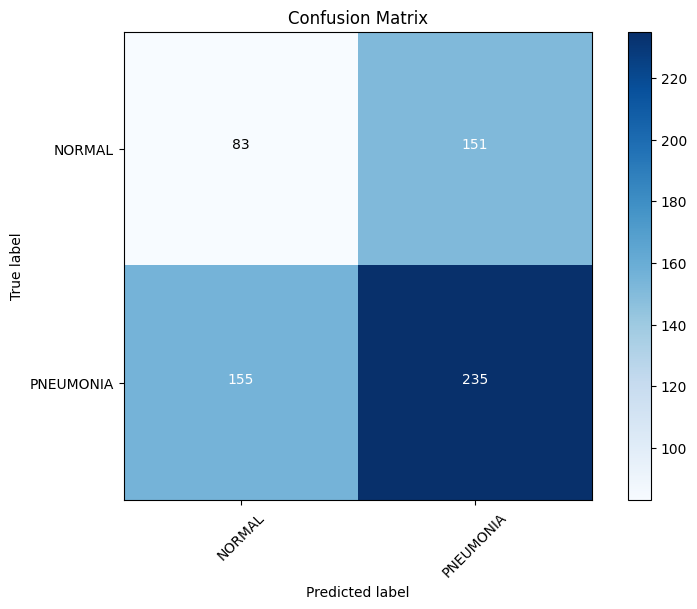

In [20]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix')


In [21]:
# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.35      0.35      0.35       234
   PNEUMONIA       0.61      0.60      0.61       390

    accuracy                           0.51       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.51      0.51      0.51       624

